In [ ]:
# Copyright 2021 NVIDIA CORPORATION
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt, time
import cudf, numpy as np, pandas as pd
import cupy, gc
cudf.__version__

'0.19.1'

In [2]:
VER = 146
TRAIN_SUB = False

POSTFIX = 'a'
FLIP = False

In [3]:
# ALL OF GIBA PREPROCESS FEATURES
ALL = ['hashtags', 'tweet_id', 'media', 'links', 'domains', 'tweet_type',
       'language', 'timestamp', 'a_user_id', 'a_follower_count',
       'a_following_count', 'a_is_verified', 'a_account_creation', 'b_user_id',
       'b_follower_count', 'b_following_count', 'b_is_verified',
       'b_account_creation', 'b_follows_a', 'reply', 'retweet',
       'retweet_comment', 'like', 'text', 'tw_len_media', 'tw_len_photo',
       'tw_len_video', 'tw_len_gif', 'tw_len_quest', 'tw_len_token',
       'tw_count_capital_words', 'tw_count_excl_quest_marks',
       'tw_count_special1', 'tw_count_hash', 'tw_last_quest', 'tw_len_retweet',
       'tw_len_rt', 'tw_count_at', 'tw_count_words', 'tw_count_char',
       'tw_rt_count_words', 'tw_rt_count_char', 'tw_original_user0',
       'tw_original_user1', 'tw_original_user2', 'tw_rt_user0',
       'tw_original_http0', 'tw_word0', 'tw_word1', 'tw_word2', 'tw_word3',
       'tw_word4', 'tw_tweet', 'group', 'dt_day', 'dt_dow', 'dt_minute',
       'len_hashtags', 'len_links', 'len_domains']

# Numerical Features

In [4]:
FEATS = ['b_follows_a','a_follower_count','a_following_count','b_follower_count','b_following_count']#,
#        'a_account_creation','b_account_creation']#,
#        'a_is_verified','b_is_verified']

FEATS += ['dt_dow', 'dt_minute',
          'len_hashtags', 'len_links', 'len_domains']

FEATS += ['tw_len_media', 'tw_len_photo','tw_len_video', 'tw_len_gif', 
          'tw_len_quest', 'tw_len_token',
          'tw_count_capital_words', 'tw_count_excl_quest_marks',
          'tw_count_special1', 'tw_count_hash', 'tw_last_quest', 
          'tw_len_retweet', 'tw_len_rt', 'tw_count_at', 'tw_count_words', 'tw_count_char',
          'tw_rt_count_words', 'tw_rt_count_char']

# TE single column

In [5]:
TE = ['a_user_id', 'b_user_id','tweet_type','language','media',
#     'tw_original_user0',
#     'tw_original_user1', 'tw_original_user2', 
#     'tw_rt_user0',
#     'tw_original_http0', 
     'tw_word0']
#      'tw_word1', 'tw_word2', 'tw_word3', 'tw_word4',
#     'hashtags','links', 
#      'domains']

# require more than filt samples before adding to TE map
TE_filt = [1]*len(TE)
TE_SMOOTH = 20
TE_USE_1_BYTE = True

# TE multiple columns

In [6]:
TE2 =[['a_user_id','language','tweet_type'],
      ['b_user_id','language','tweet_type'],
      ['language','tweet_type','media'],
      ['a_user_id','b_user_id']]

# require more than filt samples before adding to TE map
TE2_filt = [1]*len(TE2)
TE2_SMOOTH = 20

# Load Train Valid
If columns in TE2 are not present in FEATS and TE, then add below

In [7]:
TARS = ['reply', 'retweet','retweet_comment', 'like']
COLS = TARS + TE + FEATS

In [8]:
train = pd.read_parquet(f'../may-14-21-RECSYS/train6{POSTFIX}.parquet',columns=COLS).reset_index(drop=True)
print( train.shape )
train.head()

(31977926, 38)


,reply,retweet,retweet_comment,like,a_user_id,b_user_id,tweet_type,language,media,tw_word0,...,tw_count_special1,tw_count_hash,tw_last_quest,tw_len_retweet,tw_len_rt,tw_count_at,tw_count_words,tw_count_char,tw_rt_count_words,tw_rt_count_char
0,0,0,0,0,-738100672,1762493187,0,10,4,-708815550,...,6,0,0,0,0,0,13,57,0,0
1,0,0,0,0,768981309,-118189451,0,7,0,1704768051,...,0,0,0,0,0,0,5,41,0,0
2,0,0,0,1,1114089211,682509122,0,0,0,-954282298,...,0,0,0,0,0,0,5,27,0,0
3,0,0,0,1,1051751361,-238649212,2,4,2,-708815550,...,0,0,0,0,0,0,1,20,0,0
4,0,0,0,0,-1515818908,1750659970,0,0,1,-993226212,...,0,0,0,0,0,0,8,61,0,0


In [9]:
valid = pd.read_parquet(f'../may-14-21-RECSYS/valid6{POSTFIX}.parquet',columns=COLS).reset_index(drop=True)
print( valid.shape )
valid.head()

(17296496, 38)


,reply,retweet,retweet_comment,like,a_user_id,b_user_id,tweet_type,language,media,tw_word0,...,tw_count_special1,tw_count_hash,tw_last_quest,tw_len_retweet,tw_len_rt,tw_count_at,tw_count_words,tw_count_char,tw_rt_count_words,tw_rt_count_char
0,0,0,0,1,-1720532695,-737683714,0,1,0,-108567334,...,2,1,0,0,0,0,36,139,0,0
1,0,0,0,1,-940870246,617034320,0,5,0,-1469858158,...,2,1,0,0,0,0,48,299,0,0
2,0,0,0,0,-1434746634,-1464478894,1,0,0,1694712663,...,0,1,0,0,0,3,18,131,0,8
3,0,0,0,1,894603071,1776705041,0,1,0,-108567334,...,0,0,0,0,0,0,29,85,0,0
4,0,0,0,1,119885682,1484342501,0,0,0,1157158975,...,0,0,0,0,0,0,63,288,0,0


In [10]:
if TRAIN_SUB:
    train = pd.concat([train,valid],axis=0,ignore_index=True)
    print('We are training with all data for sub...')
    
    mn = train[TARS].mean()
    if TE_USE_1_BYTE:
        mn = (mn*255-128).astype('int8')
    print('Target means are:')
    display(mn)
else:
    print('We are training validation models...')

We are training validation models...


# Target Encoding - single column

In [11]:
TARS = ['reply','retweet','retweet_comment','like']

In [12]:
from sklearn.model_selection import KFold
def target_encode_cudf_v3(train, valid, col, col2, tar, n_folds=5, min_ct=0, smooth=20, 
                          seed=42, shuffle=False, t2=None, v2=None, x=-1, filt=0):
    #
    # col = column to target encode (or if list of columns then multiple groupby)
    # tar = tar column encode against
    # if min_ct>0 then all classes with <= min_ct are consider in new class "other"
    # smooth = Bayesian smooth parameter
    # filt = remove all classes with <= filt. Then inference uses mean
    # seed = for 5 Fold if shuffle==True
    # if x==-1 result appended to train and valid
    # if x>=0 then result returned in column x of t2 and v2
    #    
    
    # SINGLE OR MULTIPLE COLUMN
    if not isinstance(col, list): col = [col]
    if (min_ct>0)&(len(col)>1): 
        print('WARNING: Setting min_ct=0 with multiple columns. Not implemented')
        min_ct = 0
    name = "_".join(col)
        
    # FIT ALL TRAIN
    if not col2 is None:
        gf = cudf.from_pandas(train[col+[col2]+[tar]]).reset_index(drop=True)
    else:
        gf = cudf.from_pandas(train[col+[tar]]).reset_index(drop=True)
    gf['idx'] = gf.index #needed because cuDF merge returns out of order
    if min_ct>0: # USE MIN_CT?
        other = gf.groupby(col[0]).size(); other = other[other<=min_ct].index
        save = gf[col[0]].values.copy()
        gf.loc[gf[col[0]].isin(other),col[0]] = -1
    te = gf.groupby(col)[[tar]].agg(['mean','count']).reset_index(); te.columns = col + ['m','c']
    te = te.loc[te.c>filt] # apply filter
    mn = gf[tar].mean().astype('float32')
    te['smooth'] = ((te['m']*te['c'])+(mn*smooth)) / (te['c']+smooth)
    if min_ct>0: gf[col[0]] = save.copy()
    
    # PREDICT VALID
    if not col2 is None:
        gf2 = cudf.from_pandas(valid[col+[col2]]).reset_index(drop=True) 
    else:
        gf2 = cudf.from_pandas(valid[col]).reset_index(drop=True)
        
    gf2['idx'] = gf2.index
    if min_ct>0: gf2.loc[gf2[col[0]].isin(other),col[0]] = -1
    gf2 = gf2.merge(te[col+['smooth']], on=col, how='left', sort=False).sort_values('idx')
    if x==-1: valid[f'TE_{name}_{tar}'] = gf2['smooth'].fillna(mn).astype('float32').to_array()
    elif x>=0: v2[:,x] = gf2['smooth'].fillna(mn).astype('float32').to_array()
        
    if not col2 is None:
        te.columns = [col2] + ['m','c'] + ['smooth2']
        gf2 = gf2.merge(te[[col2]+['smooth2']], on=col2, how='left', sort=False).sort_values('idx')
        if x>=0: v2[:,x+1] = gf2['smooth2'].fillna(mn).astype('float32').to_array()
    
    # KFOLD ON TRAIN
    tmp = cupy.zeros((train.shape[0]),dtype='float32'); gf['fold'] = 0
    if not col2 is None:
        tmp2 = cupy.zeros((train.shape[0]),dtype='float32')
    if shuffle: # shuffling is 2x slower
        kf = KFold(n_folds, random_state=seed, shuffle=shuffle)
        for k,(idxT,idxV) in enumerate(kf.split(train)): gf.loc[idxV,'fold'] = k
    else:
        fsize = train.shape[0]//n_folds
        gf['fold'] = cupy.clip(gf.idx.values//fsize,0,n_folds-1)
    for k in range(n_folds):
        if min_ct>0: # USE MIN CT?
            if k<n_folds-1: save = gf[col[0]].values.copy()
            other = gf.loc[gf.fold!=k].groupby(col[0]).size(); other = other[other<=min_ct].index
            gf.loc[gf[col[0]].isin(other),col[0]] = -1
        te = gf.loc[gf.fold!=k].groupby(col)[[tar]].agg(['mean','count']).reset_index(); 
        te.columns = col + ['m','c']
        te = te.loc[te.c>filt] # apply filter
        mn = gf.loc[gf.fold!=k,tar].mean().astype('float32')
        te['smooth'] = ((te['m']*te['c'])+(mn*smooth)) / (te['c']+smooth)
        gf = gf.merge(te[col+['smooth']], on=col, how='left', sort=False).sort_values('idx')
        tmp[(gf.fold.values==k)] = gf.loc[gf.fold==k,'smooth'].fillna(mn).astype('float32').values
        del gf['smooth']
        
        if not col2 is None:
            te.columns = [col2] + ['m','c'] + ['smooth2']
            gf = gf.merge(te[[col2]+['smooth2']], on=col2, how='left', sort=False).sort_values('idx')
            tmp2[(gf.fold.values==k)] = gf.loc[gf.fold==k,'smooth2'].fillna(mn).astype('float32').values
            del gf['smooth2']
        
        #gf.drop_column('smooth')
        if (min_ct>0)&(k<n_folds-1): gf[col[0]] = save.copy()
    if x==-1: 
        train[f'TE_{name}_{tar}'] = cupy.asnumpy(tmp.astype('float32'))
    elif x>=0: 
        t2[:,x] = cupy.asnumpy(tmp.astype('float32'))
        if not col2 is None:
            t2[:,x+1] = cupy.asnumpy(tmp2.astype('float32'))

In [13]:
# CPU STORAGE FOR NEW FEATURES
# This is faster than adding each new column to Pandas dataframe
train2 = np.zeros((train.shape[0],len(TE)*4),dtype='float32')
valid2 = np.zeros((valid.shape[0],len(TE)*4),dtype='float32')

In [14]:
%%time
# cuDF TE ENCODING IS SUPER FAST!!
idx = 0; cols = []
for i,c in enumerate(TE):
    for t in ['reply', 'retweet', 'retweet_comment', 'like']:
        start = time.time()
        
        extra = None
        #if c=='a_user_id':
        #    extra = 'b_user_id'
        #elif c=='b_user_id':
        #    extra = 'a_user_id'
            
        target_encode_cudf_v3(train, valid, col=c, col2=extra, tar=t, smooth=TE_SMOOTH, filt=TE_filt[i], 
                              t2=train2, v2=valid2, x=idx, shuffle=False)
        end = time.time(); idx += 1
        cols.append(f'TE_{c}_{t}')
        print('TE',c,t,'%.1f seconds'%(end-start))
        
        if not extra is None: 
            idx += 1
            cols.append(f'TE_{c}_{t}_2')
            print('* TE',c,t,extra)

TE a_user_id reply 5.1 seconds
TE a_user_id retweet 1.8 seconds
TE a_user_id retweet_comment 1.8 seconds
TE a_user_id like 1.8 seconds
TE b_user_id reply 1.9 seconds
TE b_user_id retweet 1.9 seconds
TE b_user_id retweet_comment 1.9 seconds
TE b_user_id like 1.9 seconds
TE tweet_type reply 1.4 seconds
TE tweet_type retweet 1.4 seconds
TE tweet_type retweet_comment 1.4 seconds
TE tweet_type like 1.4 seconds
TE language reply 1.3 seconds
TE language retweet 1.4 seconds
TE language retweet_comment 1.4 seconds
TE language like 1.4 seconds
TE media reply 1.4 seconds
TE media retweet 1.4 seconds
TE media retweet_comment 1.4 seconds
TE media like 1.4 seconds
TE tw_word0 reply 1.8 seconds
TE tw_word0 retweet 1.8 seconds
TE tw_word0 retweet_comment 1.8 seconds
TE tw_word0 like 1.8 seconds
CPU times: user 26.2 s, sys: 14.9 s, total: 41.1 s
Wall time: 41.9 s


In [15]:
# USE 1 BYTE TE
if TE_USE_1_BYTE:
    train2 = (255 * train2 - 128).astype('int8')
    valid2 = (255 * valid2 - 128).astype('int8')

In [16]:
%%time
# MAKE SURE VALID HAS INDEX 0,1,2,3...
valid = pd.concat([valid,pd.DataFrame(valid2,columns=cols)],axis=1)
del valid2; x=gc.collect()

CPU times: user 1.28 s, sys: 172 ms, total: 1.45 s
Wall time: 1.44 s


In [17]:
%%time
# MAKE SURE TRAIN HAS INDEX 0,1,2,3...
train = pd.concat([train,pd.DataFrame(train2,columns=cols)],axis=1)
del train2; x=gc.collect()

CPU times: user 2.35 s, sys: 324 ms, total: 2.67 s
Wall time: 2.67 s


In [18]:
cols

['TE_a_user_id_reply',
 'TE_a_user_id_retweet',
 'TE_a_user_id_retweet_comment',
 'TE_a_user_id_like',
 'TE_b_user_id_reply',
 'TE_b_user_id_retweet',
 'TE_b_user_id_retweet_comment',
 'TE_b_user_id_like',
 'TE_tweet_type_reply',
 'TE_tweet_type_retweet',
 'TE_tweet_type_retweet_comment',
 'TE_tweet_type_like',
 'TE_language_reply',
 'TE_language_retweet',
 'TE_language_retweet_comment',
 'TE_language_like',
 'TE_media_reply',
 'TE_media_retweet',
 'TE_media_retweet_comment',
 'TE_media_like',
 'TE_tw_word0_reply',
 'TE_tw_word0_retweet',
 'TE_tw_word0_retweet_comment',
 'TE_tw_word0_like']

# Target Encode - multiple column

In [19]:
# CPU STORAGE FOR NEW FEATURES
# This is faster than adding each new column to Pandas dataframe
train2 = np.zeros((train.shape[0],len(TE2)*4),dtype='float32')
valid2 = np.zeros((valid.shape[0],len(TE2)*4),dtype='float32')

In [20]:
%%time
# cuDF TE ENCODING IS SUPER FAST!!
idx = 0; cols2 = []
for i,c in enumerate(TE2):
    for t in ['reply', 'retweet', 'retweet_comment', 'like']:
        start = time.time()
        target_encode_cudf_v3(train, valid, col=c, col2=None, tar=t, smooth=TE2_SMOOTH, filt=TE2_filt[i],
                            t2=train2, v2=valid2, x=idx, shuffle=False)
        end = time.time(); idx += 1
        #cols2.append(f'TE_mult_{t}_{i}')
        cols2.append('TE_'+'_'.join(c)+f'_{t}')
        print('TE','mult',t,'%.1f seconds'%(end-start))

TE mult reply 5.1 seconds
TE mult retweet 2.0 seconds
TE mult retweet_comment 2.0 seconds
TE mult like 2.0 seconds
TE mult reply 2.2 seconds
TE mult retweet 2.2 seconds
TE mult retweet_comment 2.2 seconds
TE mult like 2.2 seconds
TE mult reply 1.5 seconds
TE mult retweet 1.5 seconds
TE mult retweet_comment 1.5 seconds
TE mult like 1.5 seconds
TE mult reply 2.1 seconds
TE mult retweet 2.1 seconds
TE mult retweet_comment 2.1 seconds
TE mult like 2.1 seconds
CPU times: user 20 s, sys: 13.5 s, total: 33.5 s
Wall time: 34.2 s


In [21]:
# USE 1 BYTE TE
if TE_USE_1_BYTE:
    train2 = (255 * train2 - 128).astype('int8')
    valid2 = (255 * valid2 - 128).astype('int8')

In [22]:
%%time
# MAKE SURE VALID HAS INDEX 0,1,2,3...
valid = pd.concat([valid,pd.DataFrame(valid2,columns=cols2)],axis=1)
del valid2; x=gc.collect()

CPU times: user 1.06 s, sys: 206 ms, total: 1.27 s
Wall time: 1.27 s


In [23]:
%%time
# MAKE SURE TRAIN HAS INDEX 0,1,2,3...
train = pd.concat([train,pd.DataFrame(train2,columns=cols2)],axis=1)
del train2; x=gc.collect()

CPU times: user 2.05 s, sys: 300 ms, total: 2.35 s
Wall time: 2.34 s


In [24]:
cols2

['TE_a_user_id_language_tweet_type_reply',
 'TE_a_user_id_language_tweet_type_retweet',
 'TE_a_user_id_language_tweet_type_retweet_comment',
 'TE_a_user_id_language_tweet_type_like',
 'TE_b_user_id_language_tweet_type_reply',
 'TE_b_user_id_language_tweet_type_retweet',
 'TE_b_user_id_language_tweet_type_retweet_comment',
 'TE_b_user_id_language_tweet_type_like',
 'TE_language_tweet_type_media_reply',
 'TE_language_tweet_type_media_retweet',
 'TE_language_tweet_type_media_retweet_comment',
 'TE_language_tweet_type_media_like',
 'TE_a_user_id_b_user_id_reply',
 'TE_a_user_id_b_user_id_retweet',
 'TE_a_user_id_b_user_id_retweet_comment',
 'TE_a_user_id_b_user_id_like']

# More Features

In [25]:
train['ff_a_ratio'] = (train['a_follower_count'] / (train['a_following_count']+1)).astype('float32')
train['ff_b_ratio'] = (train['b_follower_count'] / (train['b_following_count']+1)).astype('float32')

valid['ff_a_ratio'] = (valid['a_follower_count'] / (valid['a_following_count']+1)).astype('float32')
valid['ff_b_ratio'] = (valid['b_follower_count'] / (valid['b_following_count']+1)).astype('float32')

# XGB Model

In [26]:
xgb_parms = { 
    'max_depth':8, 
    'learning_rate':0.1, 
    'subsample':0.8,
    'colsample_bytree':0.8, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    #'tree_method':'hist',
    #'nthread' : 16,
}

import xgboost as xgb
print('XGB Version',xgb.__version__)

XGB Version 1.4.0


In [27]:
TARGETS = ['reply','retweet','retweet_comment','like']
FEATS = FEATS + cols + cols2 + ['ff_a_ratio','ff_b_ratio']
np.array(FEATS)

array(['b_follows_a', 'a_follower_count', 'a_following_count',
       'b_follower_count', 'b_following_count', 'dt_dow', 'dt_minute',
       'len_hashtags', 'len_links', 'len_domains', 'tw_len_media',
       'tw_len_photo', 'tw_len_video', 'tw_len_gif', 'tw_len_quest',
       'tw_len_token', 'tw_count_capital_words',
       'tw_count_excl_quest_marks', 'tw_count_special1', 'tw_count_hash',
       'tw_last_quest', 'tw_len_retweet', 'tw_len_rt', 'tw_count_at',
       'tw_count_words', 'tw_count_char', 'tw_rt_count_words',
       'tw_rt_count_char', 'TE_a_user_id_reply', 'TE_a_user_id_retweet',
       'TE_a_user_id_retweet_comment', 'TE_a_user_id_like',
       'TE_b_user_id_reply', 'TE_b_user_id_retweet',
       'TE_b_user_id_retweet_comment', 'TE_b_user_id_like',
       'TE_tweet_type_reply', 'TE_tweet_type_retweet',
       'TE_tweet_type_retweet_comment', 'TE_tweet_type_like',
       'TE_language_reply', 'TE_language_retweet',
       'TE_language_retweet_comment', 'TE_language_like',
  

In [28]:
np.random.seed(42)

if TRAIN_SUB: 
    if PROP>=0.99:
        IDX = np.arange(len(train))
    else:
        IDX = np.random.choice(np.arange(len(train)),int(0.5*len(train)),replace=False)
        if FLIP: IDX = np.setdiff1d(np.arange(len(train)),IDX)
    try: os.mkdir('./m%i'%VER)
    except: print('Note: ver %i folder already exists'%VER)
else:
    IDX = np.random.choice(np.arange(len(train)),len(train)//3,replace=False)
        
np.random.seed(seed=None)
    
# SET THESE TO VALUES DISCOVERED WITH VALIDATION
ROUNDS = [250,250,200,250]

print(IDX[:10])

[21976281  7023695 28623887 18625080 27647273  3950061 30408931  5775773
 22525931  9326101]


In [29]:
len(train)

31977926

In [30]:
oof = np.zeros((len(valid),4))

for k in range(4):
    print('#'*25)
    print('###',TARGETS[k])
    print('#'*25)
    
    dtrain = xgb.DMatrix(data=train.loc[IDX,FEATS], label=train.loc[IDX,TARGETS[k]] )
    if not TRAIN_SUB: dvalid = xgb.DMatrix(data=valid[FEATS], label=valid[TARGETS[k]] )

    if TRAIN_SUB:
        model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train')],
                num_boost_round=ROUNDS[k],
                verbose_eval=25) 
        model.save_model('./m%i/XGB_%s_%s'%(VER,TARGETS[k],POSTFIX))
        gc.collect()
    else:
        model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=250,
                early_stopping_rounds=25,
                #maximize=True,
                verbose_eval=25) 

        oof[:,k] = model.predict(dvalid)

#########################
### reply
#########################
[0]	train-logloss:0.60652	valid-logloss:0.60665
[25]	train-logloss:0.11071	valid-logloss:0.11263
[50]	train-logloss:0.08858	valid-logloss:0.09130
[75]	train-logloss:0.08676	valid-logloss:0.08994
[100]	train-logloss:0.08602	valid-logloss:0.08959
[125]	train-logloss:0.08553	valid-logloss:0.08943
[150]	train-logloss:0.08511	valid-logloss:0.08931
[175]	train-logloss:0.08473	valid-logloss:0.08924
[200]	train-logloss:0.08437	valid-logloss:0.08917
[225]	train-logloss:0.08406	valid-logloss:0.08914
[249]	train-logloss:0.08378	valid-logloss:0.08911
#########################
### retweet
#########################
[0]	train-logloss:0.62189	valid-logloss:0.62160
[25]	train-logloss:0.22635	valid-logloss:0.22858
[50]	train-logloss:0.21086	valid-logloss:0.21574
[75]	train-logloss:0.20837	valid-logloss:0.21411
[100]	train-logloss:0.20698	valid-logloss:0.21329
[125]	train-logloss:0.20605	valid-logloss:0.21282
[150]	train-logloss:0.20533	valid-

# Compute Metrics

In [31]:
from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
  prec, recall, thresh = precision_recall_curve(gt, pred)
  prauc = auc(recall, prec)
  return prauc

def calculate_ctr(gt):
  positive = len([x for x in gt if x == 1])
  ctr = positive/float(len(gt))
  return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# FAST METRIC FROM GIBA
def compute_rce_fast(pred, gt):
    cross_entropy = log_loss(gt, pred)
    yt = np.mean(gt)     
    strawman_cross_entropy = -(yt*np.log(yt) + (1 - yt)*np.log(1 - yt))
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

In [32]:
%%time
if not TRAIN_SUB:
    txt = ''; tot=0
    for i in range(4):
        prauc = compute_prauc(oof[:,i], valid[TARGETS[i]].values )
        rce   = compute_rce_fast(oof[:,i], valid[TARGETS[i]].values )
        txt_ = f"{TARGETS[i]:20} PRAUC:{prauc:.5f} RCE:{rce:.5f}"
        print(txt_)
        txt += txt_ + '\n'
        tot += rce
    print()
    print('Total = %.5f'%tot)
    print()

reply                PRAUC:0.27238 RCE:26.53904
retweet              PRAUC:0.48842 RCE:29.12610
retweet_comment      PRAUC:0.08683 RCE:16.64472
like                 PRAUC:0.77722 RCE:27.86021

Total = 100.17007

CPU times: user 34.7 s, sys: 2.11 s, total: 36.8 s
Wall time: 36.8 s


# Feature Importance - Like Model

<AxesSubplot:title={'center':'Feature Importance by WEIGHT'}, xlabel='F score', ylabel='Features'>

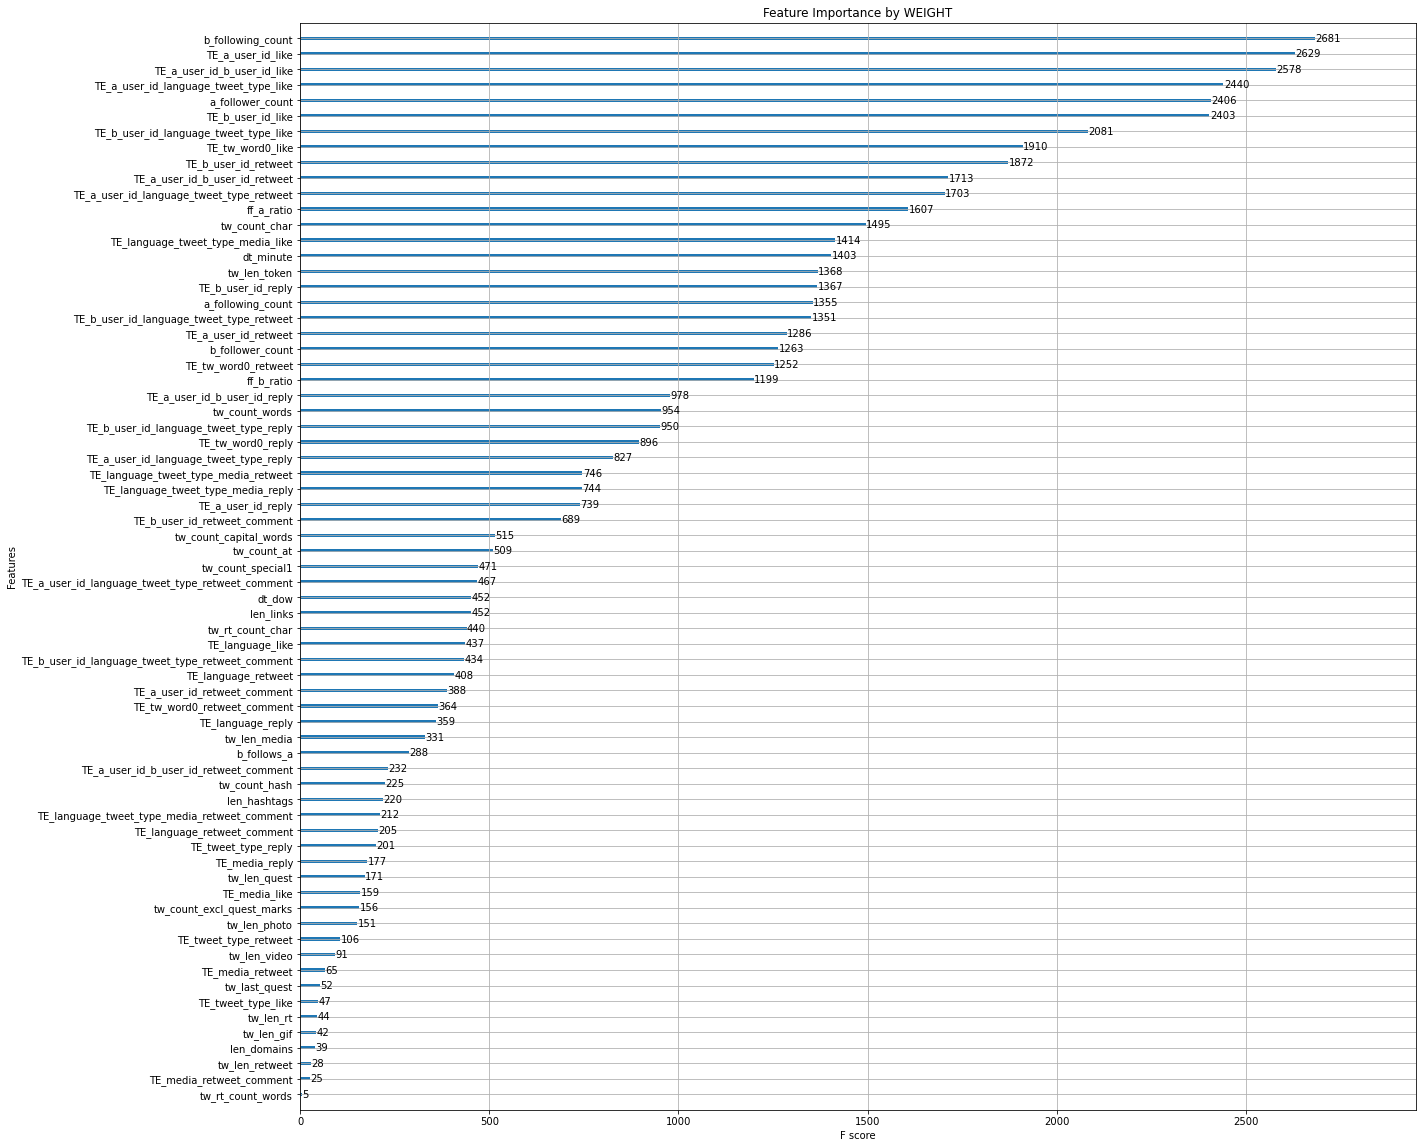

In [33]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20,20)
xgb.plot_importance(model,ax1,importance_type='weight',title='Feature Importance by WEIGHT')

<AxesSubplot:title={'center':'Feature Importance by GAIN'}, xlabel='F score', ylabel='Features'>

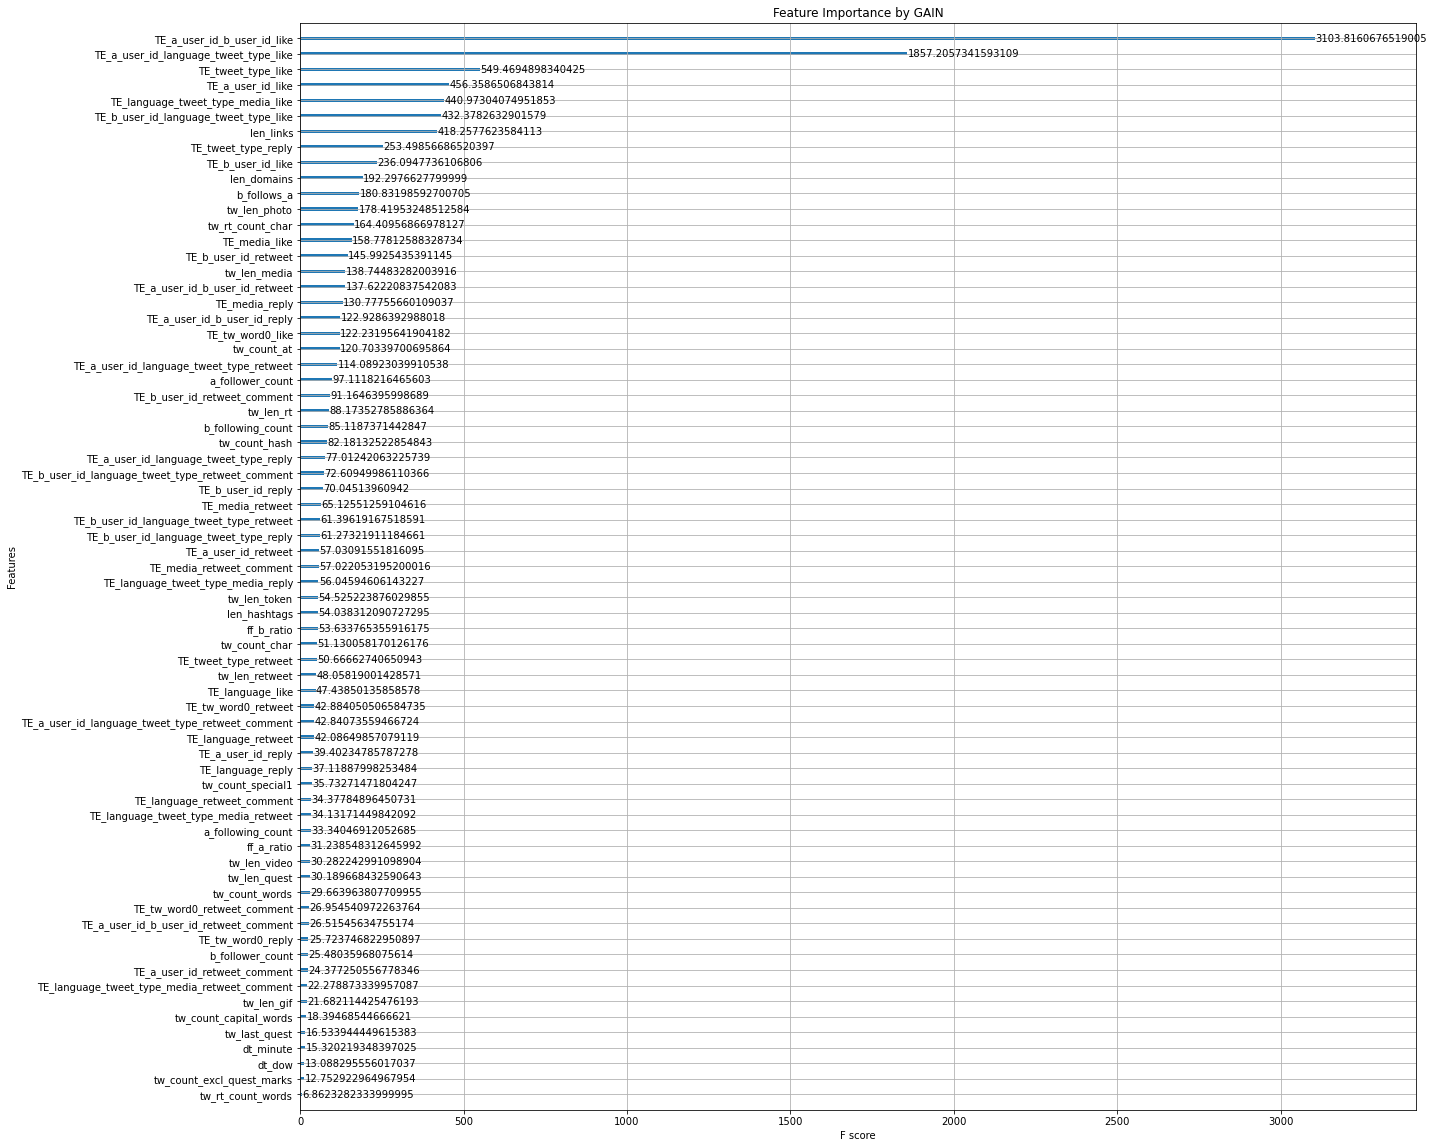

In [34]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20,20)
xgb.plot_importance(model,ax1,importance_type='gain',title='Feature Importance by GAIN')